In [1]:
from torchvision.utils import make_grid
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import numpy as np
import os

In [2]:
kim=torch.randn(3,4,5)
anh=kim.permute(2,1,0)
anh.shape

torch.Size([5, 4, 3])

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,root_dir,transform=None):
        paths=os.listdir(root_dir)
        self.paths = paths*10
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.paths[idx])
        sample = plt.imread(img_name)
      
        if self.transform:
            sample=self.transform(sample)

        return sample
  

In [4]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):

        self.output_size = output_size

    def __call__(self, sample):
        image= sample
        output_size=self.output_size
        h, w = image.shape[:2]
        
        end_h=h-output_size
        end_w=w-output_size
    
        h_s=np.random.randint(0,end_h)
        w_s=np.random.randint(0,end_w)
    
        h_e=h_s+output_size
        w_e=w_s+output_size

        image=image[h_s:h_e,w_s:w_e,:]
  

        return image


class ToYcbcr(object):
    """Convert rgb image to Ycbcr image and keep the Y channel to feed to the SRNW. CbCr channels are stored separately.
    Output will be tensor of shape 1xHxW"""
    def __call__(self,sample):
       
        image=skimage.color.rgb2ycbcr(sample,channel_axis=-1) # of shape HxWx3
        
        image=torch.tensor(image,dtype=torch.float32)
        
        #reshape image to 3xHxW
        image=image.permute(2,0,1) 

        return image


class ToBlur(object):
    def __init__(self,kernel_size):
        self.kernel_size=kernel_size
    def __call__(self,sample):
        label=sample
        image=torchvision.transforms.functional.gaussian_blur(sample,kernel_size=self.kernel_size,sigma=(0.1,1.5))
        
        y_channel=np.expand_dims((image[0]-16.0)/235.0,axis=0) # of shape 1xHxW
        cb_channel=np.expand_dims(image[1],axis=0)
        cr_channel=np.expand_dims(image[2],axis=0)
        
        
        return {'y_channel': y_channel,
                'cb_channel':cb_channel,
                'cr_channel':cr_channel,
                'label': label}

class ToSub(object):
    def __init__(self,factor):
        self.factor=factor
    def __call__(self,sample):
        y_channel,cb_channel,cr_channel=sample['y_channel'],sample['cb_channel'],sample['cr_channel']
        label=sample['label']
        
        factor=self.factor
        y_channel=y_channel[:,::factor,::factor]
        cb_channel=cb_channel[:,::factor,::factor]
        cr_channel=cr_channel[:,::factor,::factor]
        
        return {'y_channel': y_channel,
                'cb_channel':cb_channel,
                'cr_channel':cr_channel,
                'label': label}


                                                     

In [15]:
transformer=transforms.Compose([
                        RandomCrop(200),
                        ToYcbcr(),
                       ToBlur(kernel_size=3),
                       ToSub(factor=2)
                        ]
                      )

In [16]:
dataset=Dataset(root_dir='D:/KA_PRIVATE/SRNW/beau/SR_testing_datasets/BSDS100',transform=transformer)

In [17]:
dataloader=DataLoader(dataset,batch_size=36,shuffle=True,num_workers=0)

In [18]:
data_iter=iter(dataloader)
one_batch=next(data_iter)

## Initiate model and load model

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [20]:
class SuperReso(nn.Module):
    def __init__(self):
        super(SuperReso,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 5,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        self.batchnorm1=nn.BatchNorm2d(64)
        self.prelu1=nn.PReLU(init=0.2)
        
        self.conv2 = nn.Conv2d(64,32 ,3,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        self.batchnorm2=nn.BatchNorm2d(32)
        self.prelu2=nn.PReLU(init=0.2)
        
        self.conv3=nn.Conv2d(32,4,3,padding='same')
        # nn.init.normal_(self.conv1.weight,mean=0,std=0.001)
        
        self.subpixel=nn.PixelShuffle(2)

    def forward(self, x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.prelu1(x)
        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.prelu2(x)
        x=self.conv3(x)
        x=self.subpixel(x)
        
        return x

In [21]:
model=SuperReso()
model.load_state_dict(torch.load('model_185.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

## Test performance of SRNW
Pass y_channel through SRNW, interpolate cb and cr channel using bicubic interpolation.

In [22]:
#given a batch , produce result from SRNW and compare with label images
def assemble_img(batch,factor):
    y_channel=batch['y_channel'] # Bx1xHxW
    cb_channel=batch['cb_channel']
    cr_channel=batch['cr_channel']
    
    
    # pass y_channel
    yc=model(y_channel).detach().cpu() # of shape Bx1xHxW
    yc=yc*235.0+16.0
    output_size=(y_channel.shape[2]*factor,y_channel.shape[3]*factor)
    trans=torchvision.transforms.Resize(output_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    
    cb=trans.forward(cb_channel)
    cr=trans.forward(cr_channel)
    cy=trans.forward(y_channel*235.0+16.0)
    
    cb=torch.clamp(cb,min=16.0,max=240.0)
    cr=torch.clamp(cr,min=16.0,max=240.0)
    cy=torch.clamp(cy,min=16.0,max=235.0)
    yc=torch.clamp(yc,min=16.0,max=235.0)
    
    
    sr_img=torch.concatenate((yc,cb,cr),dim=1)
    
    bi_img=torch.concatenate((cy,cb,cr),dim=1)
    

    return bi_img,sr_img,batch['label']

In [23]:
#given a batch of input image (torch tensor) in ycbcr space of shape Bx3xHxW=> rgb of shape HxWx3
def convert2rgb(img):
    img=img.permute(0,2,3,1)
    img=np.array(img,dtype=np.float32)
    result=map(skimage.color.ycbcr2rgb,list(img))
    
    return list(result)

def conv(img):
    img=img.permute(0,2,3,1)
    img=np.array(img,dtype=np.float32)
    return img
    

In [32]:
bi_img,sr_img,hr_img=assemble_img(one_batch,2)
list_hr=conv(hr_img)
list_sr=conv(sr_img)
list_bi=conv(bi_img)


In [33]:
list_hr[0].shape

(200, 200, 3)

In [34]:
hr_img[0][0]

tensor([[122.5611, 120.2320, 121.5434,  ..., 135.2949, 135.2949, 137.8714],
        [120.2320, 120.6846, 121.5434,  ..., 137.6240, 139.5890, 139.5890],
        [122.4022, 118.9669, 118.0987,  ..., 146.2122, 150.5064, 151.3652],
        ...,
        [116.4360, 125.0242, 129.3183,  ..., 175.8030, 178.9205, 184.0735],
        [121.7847, 125.2200, 128.4595,  ..., 186.7625, 185.2406, 185.2406],
        [122.6436, 122.6436, 125.2200,  ..., 195.3507, 187.0098, 183.5745]])

In [18]:
sr_img[0][0]

tensor([[100.8883,  99.2820,  94.4133,  ...,  91.0702,  92.0767,  88.5348],
        [102.3636,  86.5936,  94.1051,  ...,  97.5497,  89.4665,  91.8535],
        [ 94.1620,  86.6050,  98.7512,  ...,  86.8369,  91.0208,  83.8633],
        ...,
        [108.5965, 102.6087, 103.9164,  ..., 109.5385,  97.8391, 103.6216],
        [112.0056, 101.0092, 104.6960,  ..., 108.1814, 108.0838, 109.1426],
        [105.7116, 112.9566, 107.3308,  ..., 104.6579, 112.5731, 102.8877]])

In [19]:
bi_img[0][0]

tensor([[129.3002, 129.3484, 129.3596,  ..., 126.9177, 126.6355, 126.5412],
        [129.3022, 129.3484, 129.3489,  ..., 126.9425, 126.7015, 126.6185],
        [129.3073, 129.3484, 129.3126,  ..., 126.9477, 126.8535, 126.8076],
        ...,
        [141.6798, 141.9640, 142.7016,  ..., 142.9405, 142.6588, 142.5513],
        [141.6730, 142.0105, 142.9833,  ..., 143.4488, 143.2030, 143.1055],
        [141.7434, 142.0972, 143.1441,  ..., 143.6613, 143.4253, 143.3303]])

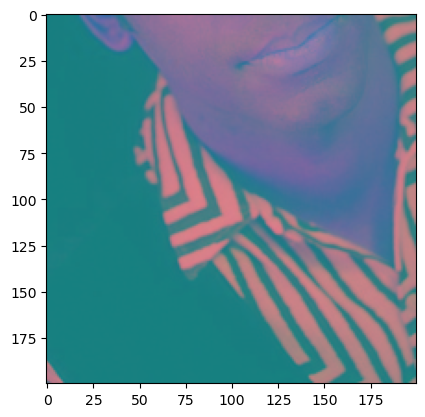

In [39]:
plt.imshow(list_hr[9]/255.0)

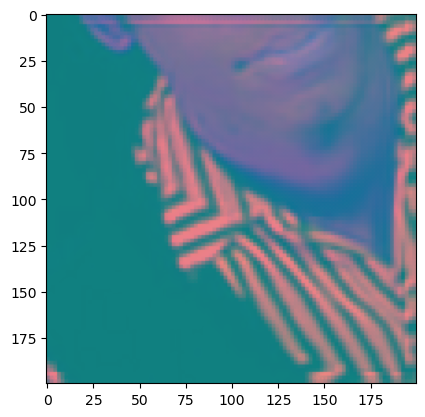

In [40]:
plt.imshow(list_sr[9]/255.0)

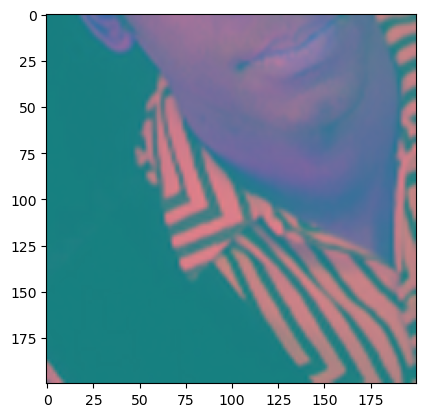

In [41]:
plt.imshow(list_bi[9]/255.0)

In [69]:
list_hr[0][:,:,1]

array([[0.55294114, 0.5490196 , 0.5529412 , ..., 0.5686274 , 0.572549  ,
        0.5764706 ],
       [0.53725487, 0.545098  , 0.5529412 , ..., 0.57254905, 0.5764706 ,
        0.57647055],
       [0.54117644, 0.5411765 , 0.5333333 , ..., 0.572549  , 0.5686275 ,
        0.5803922 ],
       ...,
       [0.58823526, 0.57254905, 0.5568627 , ..., 0.5490196 , 0.5411765 ,
        0.5490196 ],
       [0.5960784 , 0.57647055, 0.56470585, ..., 0.5607843 , 0.5490196 ,
        0.5568628 ],
       [0.59607846, 0.58823526, 0.5803921 , ..., 0.5490196 , 0.545098  ,
        0.545098  ]], dtype=float32)

In [92]:
img=plt.imread('/kaggle/input/doraemon/test/frame_tmsec_2435000.jpeg')
ycb=skimage.color.rgb2ycbcr(img,channel_axis=-1)
ycb[]

array([[[ 57.20549412, 173.61748627, 101.07124706],
        [ 58.06431765, 173.61748627, 101.07124706],
        [ 58.37263529, 172.44806275, 100.84631373],
        ...,
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373]],

       [[ 58.06431765, 173.61748627, 101.07124706],
        [ 58.06431765, 173.61748627, 101.07124706],
        [ 58.37263529, 172.44806275, 100.84631373],
        ...,
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373]],

       [[ 58.06431765, 173.61748627, 101.07124706],
        [ 58.06431765, 173.61748627, 101.07124706],
        [ 58.37263529, 172.44806275, 100.84631373],
        ...,
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373],
        [ 55.79616471, 172.44806275, 100.84631373]],

       ...,

      

In [73]:
img=np.array([[1,1],[2,2]])
test=list(img)
test

[array([1, 1]), array([2, 2])]

In [31]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 54, 54)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

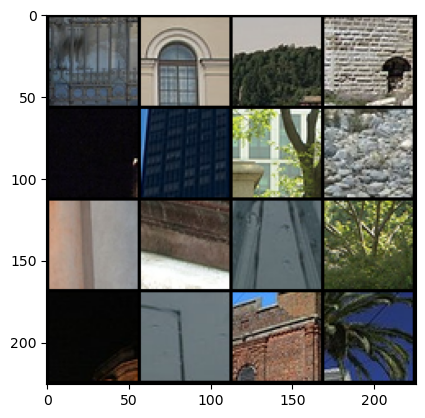

In [33]:
show_tensor_images(one_batch['landmarks'],num_images=16)

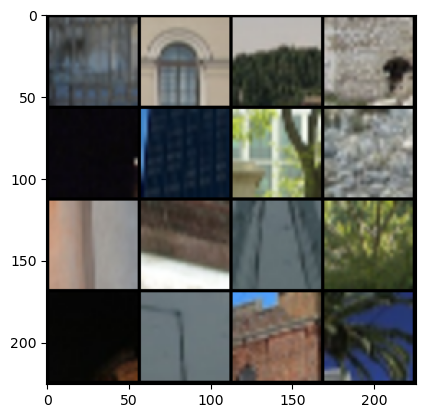

In [35]:
show_tensor_images(one_batch['image'],num_images=16)